In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

In [27]:
df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

print(df.shape)
df.head()

(70692, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [28]:
# Train/test split
train, test = train_test_split(df, test_size=0.2, random_state=21)
X_train, y_train = train.drop(columns = ['Diabetes_binary']), train['Diabetes_binary']
X_test, y_test = test.drop(columns = ['Diabetes_binary']), test['Diabetes_binary']
assert X_train.shape[0] == len(y_train)

In [29]:
# hyper-parameter tuning process
xgb = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=500,
    max_depth=2,
    min_child_weight=2,
    gamma=0.4,
    subsample=0.6,
    colsample_bytree=0.65,
    reg_alpha = 0.1,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

# ran multiple parameter tests, only one shown here
param_test1 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch = GridSearchCV(xgb, param_grid = param_test1, scoring='accuracy',n_jobs=4, cv=5)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'gamma': 0.3}, 0.7545842192849836)

In [30]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix 

model = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=500,
    max_depth=2,
    min_child_weight=2,
    gamma=0.4,
    subsample=0.6,
    colsample_bytree=0.65,
    reg_alpha = 0.1,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

model.fit(X_train, y_train)

# Standardizing t5he features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

cv_scores = cross_val_score(model, X_train_scaled, y_train, scoring='accuracy', cv=5)
cv_scores.mean(), cv_scores.std()

pred_scores = model.predict_proba(X = X_test)[:, 1] # predicted probability of diabetes
pred_labels = model.predict(X = X_test) # predicted label of diabetes


acc_score = accuracy_score(y_true = y_test, y_pred = pred_labels)
pre_score = precision_score(y_true = y_test, y_pred = pred_labels)
rec_score = recall_score(y_true = y_test, y_pred = pred_labels)
f1 = f1_score(y_true = y_test, y_pred = pred_labels)

print(f"accuracy: {acc_score}")
print(f"precision: {pre_score}")
print(f"recall: {rec_score}")
print(f"f1: {f1}")

model_pred = model.predict(X_test)
# print classification report 
print(classification_report(y_test, model_pred)) 

accuracy: 0.7534479100360705
precision: 0.7340536318667014
recall: 0.7962439988703756
f1: 0.7638851259821187
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74      7057
         1.0       0.73      0.80      0.76      7082

    accuracy                           0.75     14139
   macro avg       0.76      0.75      0.75     14139
weighted avg       0.76      0.75      0.75     14139



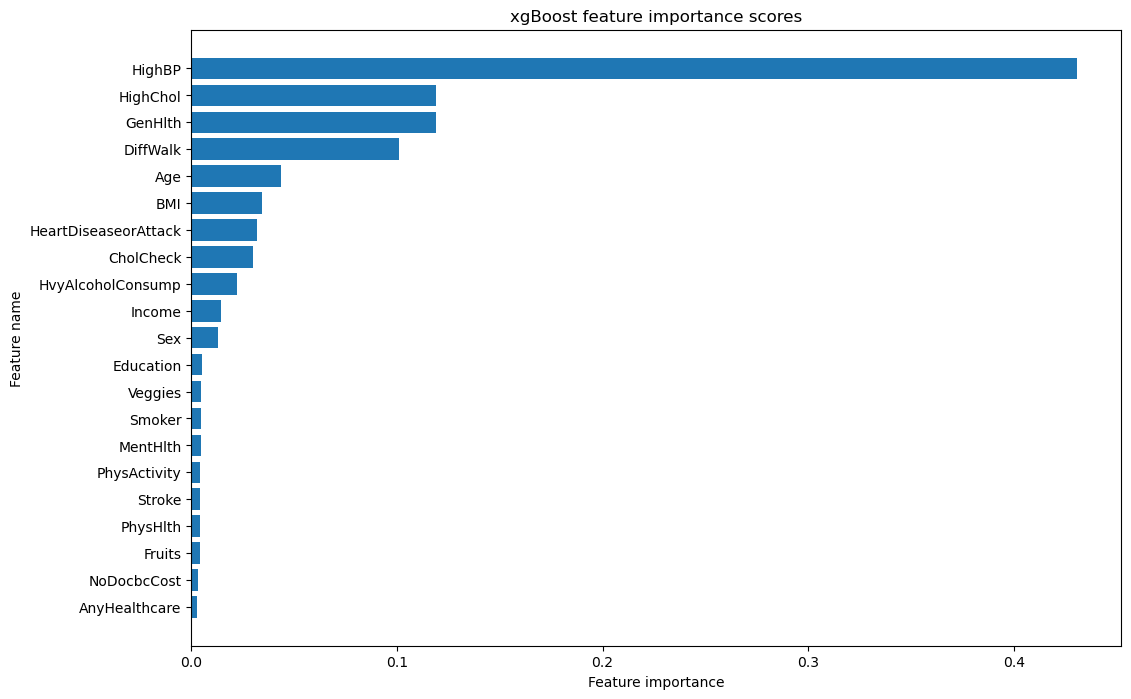

In [31]:
# xgBoost feature importance scores
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# Create a DataFrame to hold feature names and their importance scores
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importances = importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(importances['Feature'], importances['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature importance')
plt.ylabel('Feature name')
plt.title('xgBoost feature importance scores')
plt.show()

In [32]:
# Rounding the importance scores to four decimal places
importances_rounded = importances.copy()
importances_rounded['Importance'] = importances_rounded['Importance'].round(4)
importances_rounded

,Feature,Importance
HighBP,HighBP,0.4308
HighChol,HighChol,0.1189
GenHlth,GenHlth,0.1188
DiffWalk,DiffWalk,0.1008
Age,Age,0.0435
BMI,BMI,0.0343
HeartDiseaseorAttack,HeartDiseaseorAttack,0.0318
CholCheck,CholCheck,0.0299
HvyAlcoholConsump,HvyAlcoholConsump,0.0220
Income,Income,0.0144


In [33]:
# define confusion matrix
def confusio_matrix(y_test, y_predicted):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()


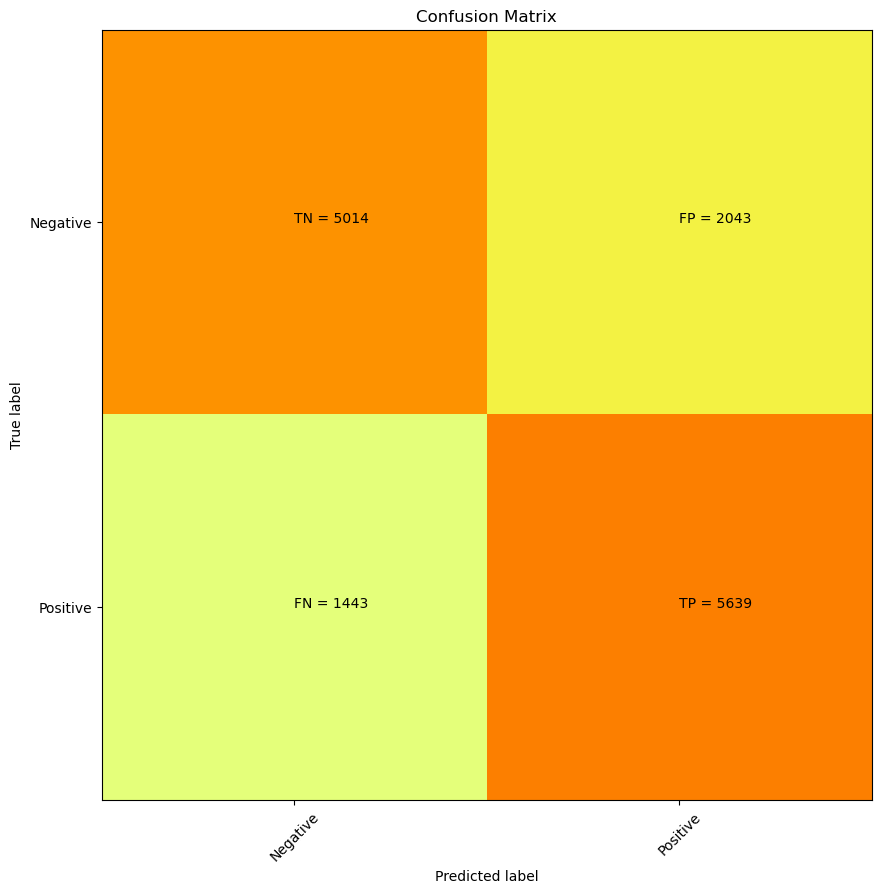

In [34]:
confusio_matrix(y_test, model_pred)